# Глубинное обучение 1 / Введение в глубинное обучение, ФКН ВШЭ

## Домашнее задание 2: сверточный классификатор.

### Общая информация

Оценка после штрафа после мягкого дедлайна вычисляется по формуле $M_{\text{penalty}} = M_{\text{full}} \cdot 0.85^{t/1440}$, где $M_{\text{full}}$ — полная оценка за работу без учета штрафа, а $t$ — время в минутах, прошедшее после мягкого дедлайна (округление до двух цифр после запятой). Таким образом, спустя первые сутки после мягкого дедлайна вы не можете получить оценку выше 8.5, а если сдать через четыре дня после мягкого дедлайна, то ваш максимум — 5.22 балла.

### Оценивание и штрафы

Максимально допустимая оценка за работу — 10 баллов. Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит познакомиться со сверточными сетями и их обучением для классификации изображений с использованием библиотеки PyTorch.


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

## 0. Загрузка данных

Работать мы будем с набором данных [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html). CIFAR10 представляет собой набор изображений 32х32 пикселя, разделенных на 10 классов.

![title](https://pytorch.org/tutorials/_images/cifar10.png)




Набор данных уже определен в <code>torchvision.datasets</code>, так что возьмем его оттуда.



In [2]:
def get_cifar10_data(batch_size, transform_train):
    torch.manual_seed(0)
    np.random.seed(0)

    transform_test = transforms.Compose(
        [transforms.ToTensor(),
         # Переводим цвета пикселей в отрезок [-1, 1]
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )

    # Загружаем данные
    trainvalset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                               download=True, transform=transform_train)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform_test)

    # В датасете определено разбиение только на train и test,
    # так что валидацию дополнительно выделяем из обучающей выборки
    train_idx, valid_idx = train_test_split(np.arange(len(trainvalset)), test_size=0.3,
                                            shuffle=True, random_state=0)
    trainset = torch.utils.data.Subset(trainvalset, train_idx)
    valset = torch.utils.data.Subset(trainvalset, valid_idx)

    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               shuffle=True, num_workers=2)
    val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                             shuffle=False, num_workers=2)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                              shuffle=False, num_workers=2)

    return train_loader, val_loader, test_loader


In [3]:
transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64,
                                                         transform_train=transform)

100%|██████████| 170M/170M [00:13<00:00, 13.1MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Посмотрим на изображения:

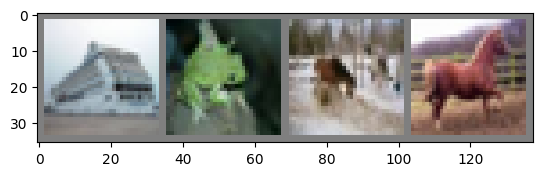

ship frog horse horse


In [4]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(*[classes[labels[i]] for i in range(4)])

## 1. Задание сверточной сети (3 балла)

Теперь нам нужно задать сверточную нейронную сеть, которую мы будем обучать классифицировать изображения.

Используем сеть, основанную на одном блоке архитектуры ResNet.

<img src="https://i.ibb.co/2hg962h/basic-block.png" width="500"/>

__Указания:__

- Все сверточные слои должны иметь 32 выходных канала, а также не должны изменять ширину и высоту изображения.
- Выход блока сократите до размерности 32х4х4, применив average pooling.
- Для получения итоговых логитов, распрямите выход пулинга в вектор из 512 элементов, а затем пропустите его через линейный слой.

**Задание 1.1 (3 балла).**

Определите архитектуру сети соответственно схеме и указаниям выше.

Ключевые слова: <code>Conv2d</code>, <code>BatchNorm2d</code>, <code>AvgPool2d</code>.

In [5]:
n_classes = 10

class BasicBlockNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv_1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding='same')
        self.bn_1 = nn.BatchNorm2d(num_features=32)
        self.relu_1 = nn.ReLU()
        self.conv_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding='same')
        self.bn_2 = nn.BatchNorm2d(num_features=32)

        self.conv_3 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=1)

        self.relu_2 = nn.ReLU()
        self.pooling = nn.AvgPool2d(8)
        self.flatten = nn.Flatten(1)
        self.linear = nn.Linear(in_features=512, out_features=n_classes)

    def forward(self, x):
        out = self.conv_1(x)
        out = self.bn_1(out)
        out = self.relu_1(out)
        out = self.conv_2(out)
        out = self.bn_2(out)

        out = out + self.conv_3(x)

        out = self.relu_2(out)
        out = self.pooling(out)
        out = self.flatten(out)
        out = self.linear(out)

        return out


In [6]:
net = BasicBlockNet()
net

BasicBlockNet(
  (conv_1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn_1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu_1): ReLU()
  (conv_2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn_2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_3): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
  (relu_2): ReLU()
  (pooling): AvgPool2d(kernel_size=8, stride=8, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=512, out_features=10, bias=True)
)

Проверим, что выход сети имеет корректную размерность:

In [7]:
assert net(torch.zeros((10, 3, 32, 32))).shape == (10, 10)

Чтобы проводить вычисления на GPU, в PyTorch необходимо руками перекладывать объекты, с которыми вы хотите проводить вычисления, на графический ускоритель. Это делается следующим образрм:

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [9]:
net = net.to(device)

Подключение GPU в google.colab:

**Среда выполнения** -> **Сменить среду выполнения** -> **Аппаратный ускоритель** -> **GPU**

## 2. Обучение и тестирование модели (3 балла)

**Задание 2.1 (2 балла).** Переходим к обучению модели. Заполните пропуски в функциях <code>test</code> и <code>train_epoch</code>. В качестве функции потерь будем использовать [кросс-энтропию](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html), а в качестве метрики качества accuracy.

In [10]:
import wandb

In [11]:
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [12]:
wandb.init(project="dl1_hw2", config={"epochs": 20}, name='sgd')

def test(model, loader):
    loss_log = []
    acc_log = []
    model.eval()

    for data, target in loader:
        with torch.no_grad():
            data, target = data.to(device), target.to(device)
            output = model(data)

            loss = F.cross_entropy(output, target)
            loss_log.append(loss.item())

            pred = output.argmax(dim=1)
            acc = (pred == target).float().mean()
            acc_log.append(acc.item())

    return np.mean(loss_log), np.mean(acc_log)

def train_epoch(model, optimizer, train_loader):
    loss_log = []
    acc_log = []
    model.train()

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

        loss_log.append(loss.item())

        pred = output.argmax(dim=1)
        acc = (pred == target).float().mean()
        acc_log.append(acc.item())

    return loss_log, acc_log

def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)

        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)

        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        wandb.log({
            "epoch": epoch,
            "train_loss": np.mean(train_loss),
            "train_accuracy": np.mean(train_acc),
            "val_loss": val_loss,
            "val_accuracy": val_acc
        })

        print(f"Epoch {epoch}")
        print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")

        if scheduler is not None:
            scheduler.step()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log


wandb: Currently logged in as: verabuylova (verabuylova-nes). Use `wandb login --relogin` to force relogin


Запустим обучение модели. В качестве оптимизатора будем использовать стохастический градиентный спуск, который является де-факто стандартом в задачах компьютерного зрения (наравне с <code>Adam</code>).

__Замечание:__ Для достижения наилучшего качества в нашем случае потребуется обучать модель несколько сотен эпох. Однако в целях экономии вашего времени и сил, во всех экспериментах мы ограничимся 20 эпохами.

In [ ]:
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader)

Epoch 0
 train loss: 0.8799638133598202, train acc: 0.6937026639743087
 val loss: 0.982918865883604, val acc: 0.6635416667512123

Epoch 1
 train loss: 0.8660852675355113, train acc: 0.6995054192473291
 val loss: 0.9835138186495355, val acc: 0.6666445037151905

Epoch 2
 train loss: 0.8545110966649309, train acc: 0.7021537935276136
 val loss: 0.9280284252572567, val acc: 0.677437943346957

Epoch 3
 train loss: 0.842328286585032, train acc: 0.7069404544734432
 val loss: 0.884249860682386, val acc: 0.6985150710065314

Epoch 4
 train loss: 0.822579243991667, train acc: 0.7147631562388139
 val loss: 0.9483350350501689, val acc: 0.6722296100981692

Epoch 5
 train loss: 0.8107182963238774, train acc: 0.7180195547762911
 val loss: 0.8971758596440579, val acc: 0.6926196808510638

Epoch 6
 train loss: 0.8027101237006772, train acc: 0.7215983285764453
 val loss: 0.9107969134411913, val acc: 0.684906914893617

Epoch 7
 train loss: 0.7892226765317063, train acc: 0.7265359754972092
 val loss: 0.89948

Посчитайте точность на тестовой выборке:

In [ ]:
_, acc = test(net, test_loader)
print(np.mean(acc))

0.7037221337579618


Если вы все сделали правильно, у вас должна была получиться точность $\ge 67\%$.

**Задание 2.2 (1 балл).** Постройте графики зависимости функции потерь и точности классификации от номера шага оптимизатора. На каждом графике расположите данные и для обучающей и для валидационной выборки, итого у вас должно получиться два графика. Обратите внимание, что на обучающей выборке эти данные считаются по каждому батчу, на валидационной же они считаются по всей выборке раз в эпоху.

In [ ]:
import matplotlib.pyplot as plt

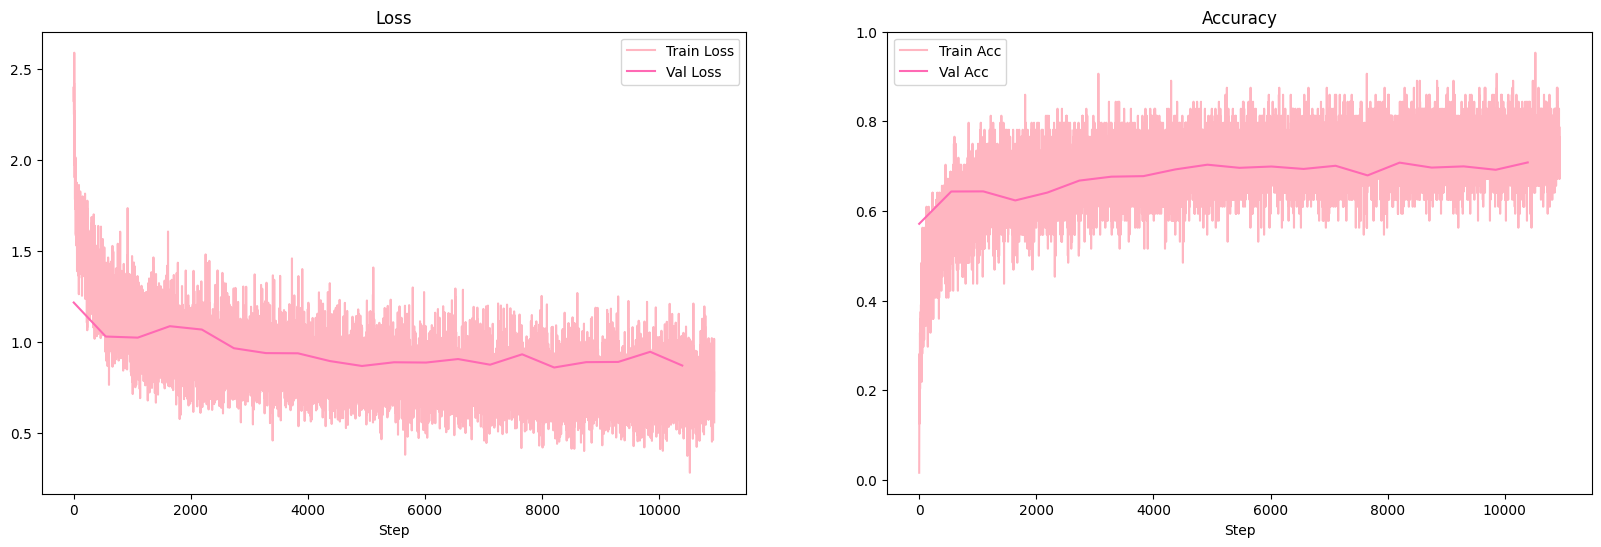

In [ ]:
plt.figure(figsize=(20, 6))

plt.subplot(1, 2, 1)
plt.plot(range(len(train_loss_log)), train_loss_log, color='lightpink', label='Train Loss')
plt.plot(
    range(0, len(train_loss_log), len(train_loss_log) // len(val_loss_log)),
    val_loss_log, color='hotpink', label='Val Loss'
)
plt.xlabel('Step')
plt.title('Loss')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(range(len(train_acc_log)), train_acc_log, color='lightpink', label='Train Acc')
plt.plot(
    range(0, len(train_acc_log), len(train_acc_log) // len(val_acc_log)),
    val_acc_log, color='hotpink', label='Val Acc'
)
plt.xlabel('Step')
plt.title('Accuracy')
plt.legend()

plt.show()


## 3. Расписание длины шага (2 балла)

С курса "Машинное обучение 1" вы уже должны знать, что сходимость стохастического градиентного спуска мы можем теоретически гарантировать только если будем определенным образом со временем уменьшать длину шага. На практике при обучении нейронных сетей такая техника оказывается очень полезной, однако теоретически обоснованными способами уменьшения длины шага фантазия не ограничивается.

Одним из простейших способов является кусочно постоянная функция: на нескольких фиксированных эпохах уменьшаем длину шага в константу раз.

In [ ]:
wandb.init(project="dl1_hw2", config={"epochs": 20}, name='sgd_const_decrease')

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▂▂▃▃▄▄▅▅▅▆▆▇▇▇▇████
train_loss,█▇▇▆▆▅▅▄▄▄▃▃▂▂▂▂▁▁▁▁
val_accuracy,▁▁▃▅▂▅▄▅▃▄▆▆▆▇█▅▅█▆▇
val_loss,██▆▄▆▄▅▄▆▅▃▃▃▂▂▄▄▁▃▂
epoch,19
train_accuracy,0.75069
train_loss,0.71564
val_accuracy,0.71578
val_loss,0.85706


In [ ]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.4915373259968034, train acc: 0.4658322995715865
 val loss: 1.2374067352173177, val acc: 0.5656914893617021

Epoch 1
 train loss: 1.1649961473736945, train acc: 0.5931011687902907
 val loss: 1.1021113809118879, val acc: 0.6204565603682335

Epoch 2
 train loss: 1.0487810771033794, train acc: 0.6373808436245544
 val loss: 1.025116853257443, val acc: 0.6459884752618505

Epoch 3
 train loss: 0.9908633603692273, train acc: 0.656560133209612
 val loss: 0.9797894749235599, val acc: 0.6596852837724888

Epoch 4
 train loss: 0.9466448060119392, train acc: 0.6689164926190699
 val loss: 1.1860698088686517, val acc: 0.604720744680851

Epoch 5
 train loss: 0.9228250803851559, train acc: 0.6784653304045989
 val loss: 1.0203835292065397, val acc: 0.6470079787234042

Epoch 6
 train loss: 0.8950826127960652, train acc: 0.6896178833527364
 val loss: 1.0484847938760797, val acc: 0.649468085106383

Epoch 7
 train loss: 0.877644604313744, train acc: 0.6943188496002114
 val loss: 0.9411

Посчитайте точность на тестовой выборке:

In [ ]:
_, acc = test(net, test_loader)
print(np.mean(acc))

0.7153662420382165


**Задание 3.0 (0.5 баллов).** Здесь может возникнуть вопрос: а что будет, если мы не будем уменьшать длину шага в процессе обучения, а сразу возьмем констатную, равную значению нашей кусочно-постоянной функции на последних эпохах, то есть $0.001$ в нашем случае. Запустите обучение и проверьте, что в таком случае мы получим худшее качество на тестовой выборке.

In [13]:
wandb.init(project="dl1_hw2", config={"epochs": 20}, name='sgd_const')

In [14]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader)

Epoch 0
 train loss: 1.8165331444749013, train acc: 0.36589187786827576
 val loss: 1.60335503943423, val acc: 0.4426640071767442

Epoch 1
 train loss: 1.5169622778238718, train acc: 0.46723197964471264
 val loss: 1.428450482449633, val acc: 0.4948581561129144

Epoch 2
 train loss: 1.3959048175724595, train acc: 0.5083980804387569
 val loss: 1.3655740920533526, val acc: 0.517686170212766

Epoch 3
 train loss: 1.3254512389355648, train acc: 0.5360121768396995
 val loss: 1.2933956704241165, val acc: 0.5462322695458189

Epoch 4
 train loss: 1.2722919054833366, train acc: 0.5545507965837579
 val loss: 1.2468991375984029, val acc: 0.5673093972053934

Epoch 5
 train loss: 1.227420234919902, train acc: 0.5691025725666304
 val loss: 1.232069253667872, val acc: 0.5658244680851063

Epoch 6
 train loss: 1.184790692338124, train acc: 0.5841277096781478
 val loss: 1.1865953590007539, val acc: 0.5921985816448293

Epoch 7
 train loss: 1.1509985678592591, train acc: 0.5977490859232175
 val loss: 1.1243

In [15]:
_, acc = test(net, test_loader)
print(np.mean(acc))

0.6621218152866242


**Задание 3.1 (1.5 балла).** Изучите, какие еще способы уменьшения длины шага представлены в <code>torch.optim.lr_scheduler</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними. Удалось ли добиться улучшения качества на тестовой выборке?

**OneCycleLR**: в начале обучения lr увеличивается с max_lr / div_factor до max_lr (гиперпараметр). После достижения max_lr, lr уменьшается до min_lr (гиперпараметр).

In [16]:
wandb.init(project="dl1_hw2", config={"epochs": 20}, name='onecyclelr')

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=2, epochs=10)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▃▄▅▅▆▆▆▆▇▇▇▇▇██████
train_loss,█▆▅▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁
val_accuracy,▁▃▃▄▅▅▆▆▆▇▇▇▇▇▇█████
val_loss,█▆▅▅▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁
epoch,19
train_accuracy,0.6778
train_loss,0.93621
val_accuracy,0.66711
val_loss,0.95902


Epoch 0
 train loss: 1.8709966397590567, train acc: 0.34393771224309583
 val loss: 1.6478064745030505, val acc: 0.42353723404255317

Epoch 1
 train loss: 1.501759221828398, train acc: 0.47096173941980113
 val loss: 1.401038694381714, val acc: 0.506626773134191

Epoch 2
 train loss: 1.354648117827323, train acc: 0.5187222513027994
 val loss: 1.275431976419814, val acc: 0.5424202127659574

Epoch 3
 train loss: 1.2413300480659526, train acc: 0.5594639592894253
 val loss: 1.194145169156663, val acc: 0.5708776595744681

Epoch 4
 train loss: 1.1478627178089273, train acc: 0.5948966767713836
 val loss: 1.0975719355522318, val acc: 0.6116799646235527

Epoch 5
 train loss: 1.0740189218869811, train acc: 0.6226127906081009
 val loss: 1.0758110150377802, val acc: 0.6152925531914893

Epoch 6
 train loss: 1.0138243393226778, train acc: 0.6454769522224092
 val loss: 1.000296991683067, val acc: 0.6480718085106383

Epoch 7
 train loss: 0.9730682057044188, train acc: 0.660465363065765
 val loss: 0.9532

In [17]:
_, acc = test(net, test_loader)
print(np.mean(acc))

0.7177547770700637


ExponentialLR: экпоненциально уменьшающийся lr.
В
$$
\text{lr}_{t+1} = \text{lr}_t \cdot \gamma
$$
где $\gamma$ - гиперпараметр, определяющий скорость уменьшения (меньше 1).

In [18]:
wandb.init(project="dl1_hw2", config={"epochs": 20}, name='exponential')

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.95)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▃▄▅▅▆▆▇▇▇▇▇▇▇██████
train_loss,█▆▅▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
val_accuracy,▁▃▄▄▅▅▆▇▆▇▇▇▇█▇█████
val_loss,█▆▅▄▃▃▃▂▃▂▂▂▂▁▁▁▁▁▁▁
epoch,19
train_accuracy,0.74423
train_loss,0.75071
val_accuracy,0.72347
val_loss,0.80523


Epoch 0
 train loss: 1.484041240795003, train acc: 0.47264298780308783
 val loss: 1.288776229290252, val acc: 0.5528590425531915

Epoch 1
 train loss: 1.1539309089100993, train acc: 0.5970676091297017
 val loss: 1.12567593188996, val acc: 0.5992686170212767

Epoch 2
 train loss: 1.0404600734248675, train acc: 0.6377929942699412
 val loss: 1.0059974870783217, val acc: 0.6479831561129143

Epoch 3
 train loss: 0.9824634508197443, train acc: 0.6595472055989602
 val loss: 1.015063997532459, val acc: 0.6538563829787234

Epoch 4
 train loss: 0.9493567451044672, train acc: 0.6699489096836808
 val loss: 0.975778840957804, val acc: 0.6634530143534884

Epoch 5
 train loss: 0.9241604317912672, train acc: 0.6805056804276908
 val loss: 0.9496582094659196, val acc: 0.673249113559723

Epoch 6
 train loss: 0.8926424534490819, train acc: 0.6900790024283163
 val loss: 0.9540332753607568, val acc: 0.671875

Epoch 7
 train loss: 0.877594138739096, train acc: 0.695996017299143
 val loss: 0.9647813365814534,

In [19]:
_, acc = test(net, test_loader)
print(np.mean(acc))

0.7170581210191083


## 4. Аугментации данных (2 балла)

Еще одной стандартной техникой, применяющейся в глубинном обучении, а особенно часто в компьютерном зрении, являются аугментации данных. Суть аугментаций состоит в том, что мы можем некоторым синтетическим образом видоизменять объекты обучающей выборки, тем самым расширяя ее, а также делая итоговую модель более устойчивой к таким изменениям.

Простейшая аугментация, которую можно применить к картинкам — разворот картинки по горизонтальной оси. То есть при обучении модели с вероятностью $0.5$ мы будем разворачивать картинку из обучающей выборки.

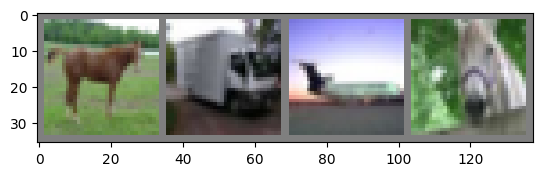

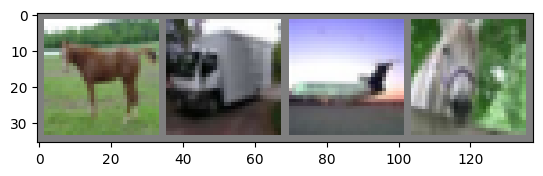

In [21]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

imshow(torchvision.utils.make_grid(transforms.functional.hflip(images[:4])))

Наиболее удобным способом работы с аугментациями в PyTorch является их задание в списке <code>transforms</code>, который затем передается в загрузчик данных. Обучим нашу сеть, применяя горизонтальные повороты:

In [23]:
wandb.init(project="dl1_hw2", config={"epochs": 20}, name='horizontal_flip')

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▄▅▆▆▆▇▇▇▇▇▇▇███████
train_loss,█▅▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
val_accuracy,▁▃▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇███
val_loss,█▆▄▄▃▃▃▃▂▄▂▂▂▂▂▂▁▁▁▁
epoch,19
train_accuracy,0.74806
train_loss,0.72787
val_accuracy,0.71973
val_loss,0.82318


In [24]:
transform = transforms.Compose(
        [transforms.RandomHorizontalFlip(),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.4876504539353756, train acc: 0.4701945678189642
 val loss: 1.3285790220220037, val acc: 0.521764184439436

Epoch 1
 train loss: 1.1933570400670417, train acc: 0.5795695678189642
 val loss: 1.1080740188030487, val acc: 0.6132092199427016

Epoch 2
 train loss: 1.0630897505845622, train acc: 0.6295540611748286
 val loss: 1.110996097706734, val acc: 0.6154255319148936

Epoch 3
 train loss: 0.9984882127432326, train acc: 0.6518061178475891
 val loss: 0.9796770519398629, val acc: 0.6624556739279565

Epoch 4
 train loss: 0.9572134985566357, train acc: 0.6684798577585865
 val loss: 1.0026125694843049, val acc: 0.6491799646235527

Epoch 5
 train loss: 0.9223821895431993, train acc: 0.6802363541705952
 val loss: 0.9307069027677496, val acc: 0.6740691489361702

Epoch 6
 train loss: 0.9029422405106058, train acc: 0.6892547010285763
 val loss: 0.9657578295849739, val acc: 0.6660682624958931

Epoch 7
 

Посчитайте точность на тестовой выборке:

In [25]:
_, acc = test(net, test_loader)
print(np.mean(acc))

0.7277070063694268


**Задание 4.1 (2 балла).** Изучите, какие еще способы аугментаций изображений представлены в <code>torchvision.transforms</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними (по отдельности и вместе). Удалось ли добиться улучшения качества на тестовой выборке?

**RandomPerspective**: изменяет положение пискселей так, что кажется, что изображение сделано под другим углом (сжимает/растягивает) - через матрицу преобразования вычисляет новую позицию пикселей. Степень искажения изображения задается гиперпараметром distortion_scale (от 0 до 1).

In [26]:
wandb.init(project="dl1_hw2", config={"epochs": 20}, name='rand_persp')

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▄▅▆▆▆▆▇▇▇██████████
train_loss,█▅▄▄▃▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▄▆▅▆▆▇▇▇██████████
val_loss,█▅▅▄▄▃▃▂▃▂▁▁▁▁▁▁▁▁▁▁
epoch,19
train_accuracy,0.75124
train_loss,0.72344
val_accuracy,0.73491
val_loss,0.77979


In [27]:
transform = transforms.Compose(
        [transforms.RandomPerspective(),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.7013073168027553, train acc: 0.3796479172418933
 val loss: 1.5225112047601252, val acc: 0.44261968085106385

Epoch 1
 train loss: 1.4557206611092828, train acc: 0.4763196983546618
 val loss: 1.3592475769367625, val acc: 0.5133421986661059

Epoch 2
 train loss: 1.317621669886971, train acc: 0.532580308221158
 val loss: 1.2582745316180777, val acc: 0.5623670212765958

Epoch 3
 train loss: 1.2303690452680291, train acc: 0.564866805970124
 val loss: 1.1884340222845686, val acc: 0.5848182624958931

Epoch 4
 train loss: 1.1791093753722293, train acc: 0.5856987791479833
 val loss: 1.351678353928505, val acc: 0.5392065603682336

Epoch 5
 train loss: 1.1481595257300563, train acc: 0.597765408769604
 val loss: 1.147330724939387, val acc: 0.5975177305809996

Epoch 6
 train loss: 1.1230069184216112, train acc: 0.6051188299817185
 val loss: 1.119402241706848, val acc: 0.6063164893617021

Epoch 7
 trai

**ColorJitter**: случайно изменяет цветовые параметры картинки, перенося их в заданный диапазон. Гиперпараметры (от 0 до 1, итоговый параметр картинки будет в пределах [1 - a, 1 + a], где a - гиперпараметр): brightness (яркость), contrast (контраст), saturation (насыщенность), hue (диапазон изменения оттенков).

In [28]:
_, acc = test(net, test_loader)
print(np.mean(acc))

0.7053144904458599


In [29]:
wandb.init(project="dl1_hw2", config={"epochs": 20}, name='color_jitter')

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▃▅▅▆▆▆▆▇▇██████████
train_loss,█▆▅▄▃▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▅▅▄▆▆▆▆▆▇█████████
val_loss,█▆▅▄▆▃▃▃▃▃▁▁▁▁▁▁▁▁▁▁
epoch,19
train_accuracy,0.67951
train_loss,0.91516
val_accuracy,0.67006
val_loss,0.95953


In [30]:
transform = transforms.Compose(
        [transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.6589464868880277, train acc: 0.41218333771721316
 val loss: 1.4342835887949517, val acc: 0.49361702127659574

Epoch 1
 train loss: 1.313622122817763, train acc: 0.5455487725721635
 val loss: 1.2209739887968023, val acc: 0.5761524823117763

Epoch 2
 train loss: 1.1964230613691063, train acc: 0.5842746148597606
 val loss: 1.1863440434983437, val acc: 0.5941046100981692

Epoch 3
 train loss: 1.1323232092848643, train acc: 0.6109297467324154
 val loss: 1.234246337160151, val acc: 0.5808067376309253

Epoch 4
 train loss: 1.0887511770293743, train acc: 0.6241185689103232
 val loss: 1.1474099144022516, val acc: 0.6035682624958931

Epoch 5
 train loss: 1.051976668442407, train acc: 0.6383316466751656
 val loss: 1.060562501055129, val acc: 0.6379432624958931

Epoch 6
 train loss: 1.0240358924952895, train acc: 0.6449138157110545
 val loss: 1.0710314410798094, val acc: 0.6245567376309252

Epoch 7
 

In [31]:
_, acc = test(net, test_loader)
print(np.mean(acc))

0.7047173566878981


## Бонус. Логирование в wandb (2 балла)

На практике специалиста по глубинному обучению часто встречаются ситуации, когда нейросеть учится на каком-то удаленном сервере. И обычно вам хочется отслеживать прогресс обучения, особенно когда время обучения модели исчисляется днями или неделями. Для таких целей существует несколько инструментов. Вероятно, самый популярный из них — [wandb](https://wandb.ai/site).

Ваша задача состоит в том, чтобы разобраться как им пользоваться, и повторить задания 2.1 и 2.2 с его использованием. Обучение вы можете запускать в этом же ноутбуке, но теперь вам необходимо через wandb логировать значения функции потерь и точности на обучающей выборке и на валидационной. Результатом работы должны быть ваш код и публичная ссылка на страничку с графиками, идентичными графикам в задании 2.2.

https://wandb.ai/verabuylova-nes/dl1_hw2?nw=nwuserverabuylova